In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [55]:
# Cargar los conjuntos de datos desde CSV
X_train = pd.read_csv("./data/splited/X_train.csv", header=None).values
y_train = pd.read_csv("./data/splited/y_train.csv", header=None).values

X_valid = pd.read_csv("./data/splited/X_valid.csv", header=None).values
y_valid = pd.read_csv("./data/splited/y_valid.csv", header=None).values

n_towers = 134

In [56]:
class TrajectoryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TrajectoryDataset(X_train, y_train)
valid_dataset = TrajectoryDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128)

In [57]:
class TrajectoryModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TrajectoryModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 80),
            nn.ReLU(),
            nn.Linear(80, 100),
            nn.ReLU(),
            nn.Linear(100, 105),
            nn.ReLU(),
            nn.Linear(105, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

In [58]:
# Configuración para GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [59]:
model = TrajectoryModel(input_dim=X_train.shape[1], output_dim=n_towers).to(device)

In [60]:
criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)  # Reduce LR si valid_loss no mejora

# Entrenamiento
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

epochs = 100
early_stop_count = 0
patience = 10  # Número de épocas sin mejora antes de detenerse

best_valid_loss = float('inf')

c:\Users\alexs\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
for epoch in range(epochs):
    # Modo entrenamiento
    model.train()
    train_loss = 0
    train_preds = []
    train_targets = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.log(), y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_targets.extend(torch.argmax(y_batch, dim=1).cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = accuracy_score(train_targets, train_preds)

    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f'saved_model/best_model_trajectory_{epoch + 1}.pt')

    # Modo validación
    model.eval()
    valid_loss = 0
    valid_preds = []
    valid_targets = []

    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs.log(), y_batch)
            valid_loss += loss.item()

            valid_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            valid_targets.extend(torch.argmax(y_batch, dim=1).cpu().numpy())

    valid_loss /= len(valid_loader)
    valid_accuracy = accuracy_score(valid_targets, valid_preds)

    # Guardar métricas
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    # Imprimir métricas de esta época
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"  Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    # Detener si no mejora
    if valid_loss < best_valid_loss:
        early_stop_count = 0
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_model/best_model_trajectory.pt')
        print("  Mejor modelo guardado.")
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print("Detención temprana activada.")
            break

    # Ajustar el learning rate
    scheduler.step(valid_loss)

Epoch 1/100
  Train Loss: 4.0985, Train Accuracy: 0.0760
  Valid Loss: 3.6966, Valid Accuracy: 0.1172
  Mejor modelo guardado.
Epoch 2/100
  Train Loss: 3.6171, Train Accuracy: 0.1229
  Valid Loss: 3.5856, Valid Accuracy: 0.1263
  Mejor modelo guardado.
Epoch 3/100
  Train Loss: 3.5521, Train Accuracy: 0.1301
  Valid Loss: 3.5380, Valid Accuracy: 0.1324
  Mejor modelo guardado.
Epoch 4/100
  Train Loss: 3.5123, Train Accuracy: 0.1375
  Valid Loss: 3.5065, Valid Accuracy: 0.1392
  Mejor modelo guardado.
Epoch 5/100
  Train Loss: 3.4882, Train Accuracy: 0.1435
  Valid Loss: 3.4905, Valid Accuracy: 0.1428
  Mejor modelo guardado.
Epoch 6/100
  Train Loss: 3.4738, Train Accuracy: 0.1467
  Valid Loss: 3.4776, Valid Accuracy: 0.1463
  Mejor modelo guardado.
Epoch 7/100
  Train Loss: 3.4640, Train Accuracy: 0.1485
  Valid Loss: 3.4678, Valid Accuracy: 0.1482
  Mejor modelo guardado.
Epoch 8/100
  Train Loss: 3.4551, Train Accuracy: 0.1498
  Valid Loss: 3.4600, Valid Accuracy: 0.1495
  Mejor m

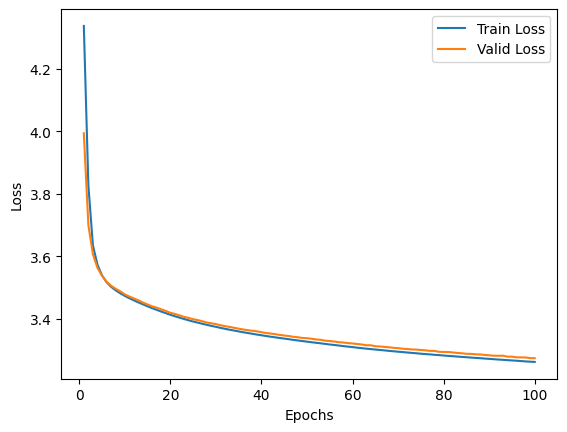

In [ ]:
# Opcional: Graficar las pérdidas
import matplotlib.pyplot as plt
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
# # Guardar el modelo
# torch.save(model.state_dict(), 'saved_model/model_trajectory.pt')